# Flow maximisation problems

A directed graph has the capacities on all the edges and our job is to find the maximum amount of flow that can happen from one node (starting node) to another node(outflow node). There are two types of flow maximisation problems:  
1. Max flow: What is the maximum flow that can be sent from source to outfow without exceeding capacity.
2. Min cost flow: We have the cost along wih capacities on each edge. We want to find the minimum cost path of sending  *f* uits of flow from source to outflow.  

We can use integer programming to solve both these problems.

In [2]:
import networkx as nx

# Other packages for manupulating data
import numpy as np
import pandas as pd

# packages for plotting
import matplotlib.pyplot as plt

## Maximum flow problem
Let us first consider the max flow problem. Consider the below graph.

In [3]:
edgelist_df = pd.DataFrame({'node1':['s', 's', 'u', 'u', 'v'], 'node2':['u', 'v', 'v', 't', 't'], 
                            'weights':[20, 10, 30, 10, 20]
                           })
edgelist_df

,node1,node2,weights
0,s,u,20
1,s,v,10
2,u,v,30
3,u,t,10
4,v,t,20


In [4]:
g = nx.DiGraph()
for i, elrow in edgelist_df.iterrows():
    g.add_edge(elrow[0], elrow[1], weight=elrow[2])
g.edges(data=True)

OutEdgeDataView([('s', 'u', {'weight': 20}), ('s', 'v', {'weight': 10}), ('u', 'v', {'weight': 30}), ('u', 't', {'weight': 10}), ('v', 't', {'weight': 20})])

In [5]:
# for each node we are trying to fix the coordinates
g.add_node('s',pos=(0,1))
g.add_node('u',pos=(1,2))
g.add_node('v',pos=(1,0))
g.add_node('t',pos=(2,1))
g.nodes(data=True)

NodeDataView({'s': {'pos': (0, 1)}, 'u': {'pos': (1, 2)}, 'v': {'pos': (1, 0)}, 't': {'pos': (2, 1)}})

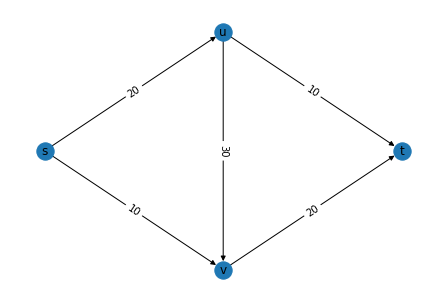

In [6]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')

# This function gets the weights for the edges 
weight = nx.get_edge_attributes(g,'weight')

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = weight)
plt.show()

We want to find the maximum flow between s and t. This can be formulated as an integer programming problem, with  
**Decision variable**
1. Integer variable $edge_{i,j} representing the amount of flow in edge ij.
2. Integer variable *f* representing the maximum flow  

In [7]:
from ortools.sat.python import cp_model
max_flow_model = cp_model.CpModel()

In [8]:
# Creating one integer decision variable for each edge
edge_int_vars = {}
for edge in g.edges:
    edge_int_vars[edge[0], edge[1]] = max_flow_model.NewIntVar(0, 100, 'edge_%s_%s' % edge)
    print('Creating the integer variable ', edge_int_vars[edge[0], edge[1]], 
          'representing the amount to flow in edge', (edge[0], edge[1]))

Creating the integer variable  edge_s_u representing the amount to flow in edge ('s', 'u')
Creating the integer variable  edge_s_v representing the amount to flow in edge ('s', 'v')
Creating the integer variable  edge_u_v representing the amount to flow in edge ('u', 'v')
Creating the integer variable  edge_u_t representing the amount to flow in edge ('u', 't')
Creating the integer variable  edge_v_t representing the amount to flow in edge ('v', 't')


**Constraints**  
The first set of constraints are flow constraints, 
1. At the input node, the net flow should be -f
2. At the output node, the net flow should be +f
3. The net flow in all other nodes should be 0

In [9]:
input_node = 's'
output_node = 't'

In [10]:
# Adding constraints on the nodes
flow = max_flow_model.NewIntVar(0, 100, 'flow') # Initialising flow this will be maximised later
for node in g.nodes:
    in_edges = g.in_edges(node)
    out_edges = g.out_edges(node)
    print('Adding the constraint on node ', node)
    equation_at_this_edge = sum(edge_int_vars[edge[0], edge[1]] for edge in in_edges) - \
                            sum(edge_int_vars[edge[0], edge[1]] for edge in out_edges)
    if(node == input_node):              
        max_flow_model.Add(equation_at_this_edge == -flow)
        print(equation_at_this_edge == -flow)
    elif(node == output_node):              
        max_flow_model.Add(equation_at_this_edge == flow)
        print(equation_at_this_edge == flow)
    else:
        max_flow_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge, '== 0')
    print('')

Adding the constraint on node  s
((-((edge_s_u) + edge_s_v)) + (1 * flow)) == 0

Adding the constraint on node  u
((edge_s_u) + -((edge_u_v) + edge_u_t)) == 0

Adding the constraint on node  v
(((edge_s_v) + edge_u_v) + -(edge_v_t)) == 0

Adding the constraint on node  t
((((edge_u_t) + edge_v_t)) + -flow) == 0



Another set of constraints are the capacity restrictions on every edge.

In [11]:
# Adding constraints on the edges
for edge in g.edges:
    print('Adding constraint on edge ', edge)
    max_flow_in_edge = g.get_edge_data(*edge)['weight']
    max_flow_model.Add(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)
    print(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)

Adding constraint on edge  ('s', 'u')
edge_s_u <= 20
Adding constraint on edge  ('s', 'v')
edge_s_v <= 10
Adding constraint on edge  ('u', 'v')
edge_u_v <= 30
Adding constraint on edge  ('u', 't')
edge_u_t <= 10
Adding constraint on edge  ('v', 't')
edge_v_t <= 20


**Objective**  
The objective is to maximise flow.

In [12]:
# The objective is to maximise flow 
max_flow_model.Maximize(flow)

Solving the problem, we get

In [13]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(max_flow_model, solution_printer)

Solution 0, time = 0.44 s, objective = 30


In [14]:
cp_model.OPTIMAL == status

True

In [15]:
result_edges = {}
for edge in g.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_int_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 20,
 ('s', 'v'): 10,
 ('u', 'v'): 10,
 ('u', 't'): 10,
 ('v', 't'): 20}

The flow in each of the nodes is shown in the figure

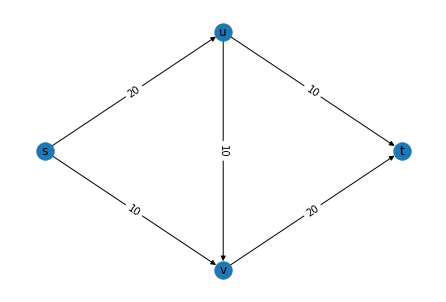

In [16]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = result_edges)
plt.show()

# Minimum cost flow problems
We want to find the minimum cost to transfer a fixed amount of flow from one edge to another. The costs are given int he table bwlow. The costs are also displayed in the network below.

In [17]:
edgelist_df = pd.DataFrame({'node1':['s', 's', 'u', 'u', 'v'], 'node2':['u', 'v', 'v', 't', 't'], 
                            'weights':[20, 10, 30, 10, 20], 'costs':[3, 2, 0.7, 1, 7]
                           })
edgelist_df

,node1,node2,weights,costs
0,s,u,20,3.0
1,s,v,10,2.0
2,u,v,30,0.7
3,u,t,10,1.0
4,v,t,20,7.0


In [18]:
g = nx.DiGraph()
for i, elrow in edgelist_df.iterrows():
    g.add_edge(elrow[0], elrow[1], weight=elrow[2], cost = elrow[3])
g.edges(data=True)

OutEdgeDataView([('s', 'u', {'weight': 20, 'cost': 3.0}), ('s', 'v', {'weight': 10, 'cost': 2.0}), ('u', 'v', {'weight': 30, 'cost': 0.7}), ('u', 't', {'weight': 10, 'cost': 1.0}), ('v', 't', {'weight': 20, 'cost': 7.0})])

In [19]:
# for each node we are trying to fix the coordinates
g.add_node('s',pos=(0,1))
g.add_node('u',pos=(1,2))
g.add_node('v',pos=(1,0))
g.add_node('t',pos=(2,1))
g.nodes(data=True)

NodeDataView({'s': {'pos': (0, 1)}, 'u': {'pos': (1, 2)}, 'v': {'pos': (1, 0)}, 't': {'pos': (2, 1)}})

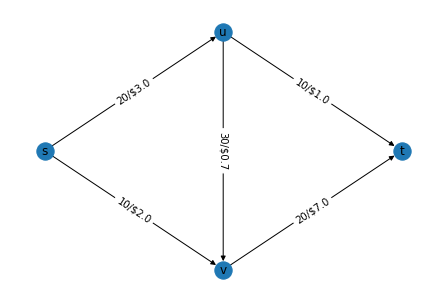

In [20]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')

# This function gets the weights for the edges 
weight = nx.get_edge_attributes(g,'weight')
cost = nx.get_edge_attributes(g,'cost')
res = {key: str(weight[key]) + '/$' + str(cost.get(key, '')) for key in cost.keys()}

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = res)
plt.show()

Just like maximum flow, we can use integer programming to find out the solution in this scenario also.   
**Decision variables**  
Integer variables $edge_{i,j}$ representing the amount of flow in edge (i,j)  
**Constraints**  
Capacity restrictions on every edge  
**Objective**
The objective is to minimise the overall cost

In [22]:
from ortools.sat.python import cp_model
min_cost_flow_model = cp_model.CpModel()

In [23]:
# Creating one integer decision variable for each edge
edge_int_vars = {}
for edge in g.edges:
    edge_int_vars[edge[0], edge[1]] = min_cost_flow_model.NewIntVar(0, 100, 'edge_%s_%s' % edge)
    print('Creating the integer variable ', edge_int_vars[edge[0], edge[1]], 
          'representing the amount to flow in edge', (edge[0], edge[1]))

Creating the integer variable  edge_s_u representing the amount to flow in edge ('s', 'u')
Creating the integer variable  edge_s_v representing the amount to flow in edge ('s', 'v')
Creating the integer variable  edge_u_v representing the amount to flow in edge ('u', 'v')
Creating the integer variable  edge_u_t representing the amount to flow in edge ('u', 't')
Creating the integer variable  edge_v_t representing the amount to flow in edge ('v', 't')


In [24]:
input_node = 's'
output_node = 't'
flow = 20 # Assuming a constant flow of 20 units

In [25]:
# Adding constraints on the nodes
for node in g.nodes:
    in_edges = g.in_edges(node)
    out_edges = g.out_edges(node)
    print('Adding the constraint on node ', node)
    print('This node has %i in-edges and %i out-edges' % (len(in_edges), len(out_edges)))
    equation_at_this_edge = sum(edge_int_vars[edge[0], edge[1]] for edge in in_edges) - \
                            sum(edge_int_vars[edge[0], edge[1]] for edge in out_edges)
    if(node == input_node):              
        min_cost_flow_model.Add(equation_at_this_edge == -flow)
        print(equation_at_this_edge == -flow)
    elif(node == output_node):              
        min_cost_flow_model.Add(equation_at_this_edge == flow)
        print(equation_at_this_edge == flow)
    else:
        min_cost_flow_model.Add(equation_at_this_edge == 0)
        print(equation_at_this_edge, '== 0')
    print('')

Adding the constraint on node  s
This node has 0 in-edges and 2 out-edges
(-((edge_s_u) + edge_s_v)) == -20

Adding the constraint on node  u
This node has 1 in-edges and 2 out-edges
((edge_s_u) + -((edge_u_v) + edge_u_t)) == 0

Adding the constraint on node  v
This node has 2 in-edges and 1 out-edges
(((edge_s_v) + edge_u_v) + -(edge_v_t)) == 0

Adding the constraint on node  t
This node has 2 in-edges and 0 out-edges
(((edge_u_t) + edge_v_t)) == 20



In [26]:
# Adding constraints on the edges
for edge in g.edges:
    print('Adding constraint on edge ', edge)
    max_flow_in_edge = g.get_edge_data(*edge)['weight']
    min_cost_flow_model.Add(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)
    print(edge_int_vars[edge[0], edge[1]] <= max_flow_in_edge)

Adding constraint on edge  ('s', 'u')
edge_s_u <= 20
Adding constraint on edge  ('s', 'v')
edge_s_v <= 10
Adding constraint on edge  ('u', 'v')
edge_u_v <= 30
Adding constraint on edge  ('u', 't')
edge_u_t <= 10
Adding constraint on edge  ('v', 't')
edge_v_t <= 20


In [27]:
# factor to make everything including costs integer
factor_to_int = 10

# The objective is to maximise flow 
total_cost = sum(int(g.get_edge_data(*edge)['cost']*factor_to_int)*edge_int_vars[edge[0], edge[1]]
                for edge in g.edges)

print('Objective is to optimise cost')
print(total_cost)
min_cost_flow_model.Minimize(total_cost)

Objective is to optimise cost
((((((30 * edge_s_u)) + (20 * edge_s_v)) + (7 * edge_u_v)) + (10 * edge_u_t)) + (70 * edge_v_t))


In [28]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(min_cost_flow_model, solution_printer)

Solution 0, time = 0.24 s, objective = 1300


In [29]:
cp_model.OPTIMAL == status

True

The solution to the minimum flow problem is

In [30]:
result_edges = {}
for edge in g.edges:
    result_edges[edge[0], edge[1]] = solver.Value(edge_int_vars[edge[0], edge[1]])
result_edges

{('s', 'u'): 10, ('s', 'v'): 10, ('u', 'v'): 0, ('u', 't'): 10, ('v', 't'): 10}

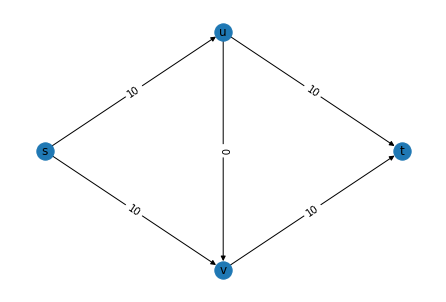

In [31]:
# This function gets the coordinates for nodes
pos = nx.get_node_attributes(g,'pos')

# The simplest way to draw a graph is by using nx.draw. 
nx.draw(g,pos, with_labels=True)

# This adds edge lables
nx.draw_networkx_edge_labels(g,pos,edge_labels = result_edges)
plt.show()